##### Add parent folder path

In [6]:
import sys; sys.path.insert(0, '..')

##### Import modules

In [7]:
import json
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam

from transformers import BertTokenizer, BertModel

from trainer.model.res_net import ResNetEmbedding
from trainer.model.image_encoder import ImageEncoder, EncoderLayer
from trainer.model.captions_decoder import CaptionsDecoder, DecoderLayer
from trainer.model.attention_layers import MultiHeadAttentionLayer
from trainer.model.position_wise_feed_forward import PositionwiseFeedforwardLayer
from trainer.model.images_to_captions import Images2Captions

from trainer.training.train import train, evaluate, epoch_time 

from trainer.preprocessing.preprocess import PreprocessData
from trainer.dataloader.dataset import RelativeCaptioningDataset, MyCollator
from trainer.vocabulary.vocab import Vocab
from trainer.embeddings.embed import PositionalEncoding, BERTEmbedding
from trainer.utils.helpers import is_any_img_blacknwhite, is_any_img_not_exist
from trainer.utils.helpers import get_params, set_seed, count_parameters, initialize_weights

##### Get params

In [8]:
params = get_params()

IMAGES_DIR = "../data/images/dresses"
TRAIN_CAPTION_META_PATH = "../data/images_metadata/cap_dress_train.json"
TRAIN_EXPLODED_SAVE_PATH = "../data/images_metadata/cap_dress_train_exploded.jsonl"
VAL_CAPTION_META_PATH = "../data/images_metadata/cap_dress_val.json"
VAL_EXPLODED_SAVE_PATH = "../data/images_metadata/cap_dress_val_exploded.jsonl"

RESNET_OUT_DIM = 1024
BERT_LAST_N_LAYERS = params['model']['bert_embedder']['last_n_layers']

ENCODER_LAYERS = params['model']['encoder']['layers']
ENCODER_HEADS = params['model']['encoder']['heads']
ENCODER_DROPOUT = params['model']['encoder']['dropout']
ENCODER_PF_DIM = params['model']['encoder']['position_ff_dim']

DECODER_LAYERS = params['model']['decoder']['layers']
DECODER_HEADS = params['model']['decoder']['heads']
DECODER_DROPOUT = params['model']['decoder']['dropout']
DECODER_PF_DIM = params['model']['decoder']['position_ff_dim']

LEARNING_RATE = params['training']['lr']
N_EPOCHS = params['training']['epochs']
CLIP = params['training']['clip']
SEED = params['global']['seed']
BATCH_SIZE = params['dataloader']['train']['batch_size']
SHUFFLE = params['dataloader']['train']['shuffle']
NUM_WORKERS = params['dataloader']['train']['num_workers']

set_seed(seed=SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# local setup
client=None

##### Set up Dataloader

In [10]:
FILTERS = [is_any_img_not_exist, is_any_img_blacknwhite]

# Preprocess data
print("======= Preprocessing train set =======")
train_filter_agent = PreprocessData(caption_meta_path=TRAIN_CAPTION_META_PATH,
                                    images_dir=IMAGES_DIR,
                                    save_path=TRAIN_EXPLODED_SAVE_PATH,
                                    filters=FILTERS,
                                    client=client)

print("======= Preprocessing val set =======")
val_filter_agent = PreprocessData(caption_meta_path=VAL_CAPTION_META_PATH,
                                  images_dir=IMAGES_DIR,
                                  save_path=VAL_EXPLODED_SAVE_PATH,
                                  filters=FILTERS,
                                  client=client)

# Get sample of train and val data in order to check training pipeline
filtered_cap_dress_train = train_filter_agent.get_filtered_data()
filtered_cap_dress_val_test = val_filter_agent.get_filtered_data()
filtered_cap_dress_val = filtered_cap_dress_val_test[:2000]
filtered_cap_dress_test = filtered_cap_dress_val_test[2000:]



# Initialize BERT tokenizer
print("======= Creatng vocabulary =======")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Initialize Vocab
vocab_train = Vocab(captions=filtered_cap_dress_train, tokenizer=tokenizer)
vocab_val = Vocab(captions=filtered_cap_dress_val, tokenizer=tokenizer)
vocab_test = Vocab(captions=filtered_cap_dress_test, tokenizer=tokenizer)
vocab = vocab_train + vocab_val + vocab_test

# Initialize Dataset
transforms_list = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

print("======= Creating train Dataset object =======")
train_rel_cap_dataset = RelativeCaptioningDataset(list_ids=filtered_cap_dress_train,
                                                  images_dir=IMAGES_DIR,
                                                  transform=transforms_list,
                                                  client=client)

print("======= Creating val Dataset object =======")
val_rel_cap_dataset = RelativeCaptioningDataset(list_ids=filtered_cap_dress_val,
                                                images_dir=IMAGES_DIR,
                                                transform=transforms_list,
                                                client=client)

print("======= Creating test Dataset object =======")
test_rel_cap_dataset = RelativeCaptioningDataset(list_ids=filtered_cap_dress_test,
                                                images_dir=IMAGES_DIR,
                                                transform=transforms_list,
                                                client=client)
# Initialize Dataloader
collate_fn = MyCollator(tokenizer=tokenizer)

print("======= Creating train Dataloader object =======")
train_generator_params = {'batch_size': BATCH_SIZE,
                          'shuffle': False,
                          'num_workers': NUM_WORKERS}
train_iterator = DataLoader(dataset=train_rel_cap_dataset, collate_fn=collate_fn, **train_generator_params)

print("======= Creating val Dataloader object =======")
val_generator_params = {'batch_size': BATCH_SIZE,
                        'shuffle': False,
                        'num_workers': NUM_WORKERS}
val_iterator = DataLoader(dataset=val_rel_cap_dataset, collate_fn=collate_fn, **val_generator_params)

print("======= Creating test Dataloader object =======")
test_generator_params = {'batch_size': BATCH_SIZE,
                        'shuffle': False,
                        'num_workers': NUM_WORKERS}
test_iterator = DataLoader(dataset=test_rel_cap_dataset, collate_fn=collate_fn, **test_generator_params)

======= Preprocessing train set =======
Captions already filtered
======= Preprocessing val set =======
Captions already filtered
======= Creatng vocabulary =======
======= Creating train Dataset object =======
0/11902 samples loaded
1000/11902 samples loaded
2000/11902 samples loaded
3000/11902 samples loaded
4000/11902 samples loaded
5000/11902 samples loaded
6000/11902 samples loaded
7000/11902 samples loaded
8000/11902 samples loaded
9000/11902 samples loaded
10000/11902 samples loaded
11000/11902 samples loaded
All samples loaded successfully
======= Creating val Dataset object =======
0/2000 samples loaded
1000/2000 samples loaded
All samples loaded successfully
======= Creating test Dataset object =======
0/2014 samples loaded
1000/2014 samples loaded
2000/2014 samples loaded
All samples loaded successfully
======= Creating train Dataloader object =======
======= Creating val Dataloader object =======
======= Creating test Dataloader object =======


##### Set up models

In [11]:
 # Get pre-trained BERT for captions embeddings
print("======= Creating BERT model =======")
pretrained_bert = BertModel.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
                                            output_hidden_states=True)
_ = pretrained_bert.eval()
bert_model = BERTEmbedding(bert_model=pretrained_bert, n_last_layers=BERT_LAST_N_LAYERS)
hid_dim = bert_model.final_dim

# Get pre-trained ResNet for images embeddings
print("======= Creating Image Model model =======")
resnet_model = models.resnet101(pretrained=True)
resnet_embedding = ResNetEmbedding(resnet=resnet_model,
                                   out_resnet=RESNET_OUT_DIM,
                                   hid_dim=hid_dim)

# Get Image Encoder model
print("======= Creating Image Encoder model =======")
encoder_model = ImageEncoder(embedding_net=resnet_embedding,
                             hid_dim=hid_dim,
                             n_layers=ENCODER_LAYERS,
                             n_heads=ENCODER_HEADS,
                             pf_dim=ENCODER_PF_DIM,
                             dropout=ENCODER_DROPOUT)

# Get Captions Decoder model
print("======= Creating Captions Decoder model =======")
#vocab_len = len(vocab)
# Because there were a change in voab size due to data cleaning process and hence the new vocab is larger, the original was 1680
vocab_len = 1680
decoder_model = CaptionsDecoder(embedding_net=bert_model,
                                hid_dim=hid_dim,
                                output_dim=vocab_len,
                                n_layers=ENCODER_LAYERS,
                                n_heads=ENCODER_HEADS,
                                pf_dim=ENCODER_PF_DIM,
                                dropout=ENCODER_DROPOUT,
                                max_length=26)

# Get Images 2 Captions model
print("======= Assembling TRIC model =======")
tric_model = Images2Captions(encoder=encoder_model,
                             decoder=decoder_model,
                             trg_pad_idx=vocab.ids_to_ids_adj[vocab.tokens_to_ids['[PAD]']])

# Initialzie weights
_ = tric_model.apply(initialize_weights)

# Print number of trainable parameters
print(f'The model has {count_parameters(tric_model):,} trainable parameters')

======= Creating BERT model =======
======= Creating Image Model model =======
======= Creating Image Encoder model =======
======= Creating Captions Decoder model =======
======= Assembling TRIC model =======
The model has 42,254,736 trainable parameters


##### Load trained model

In [12]:
MODEL_PATH = '../data/models/tric_pytorch_job_20210125_134451_models_model_20210125_155116_model.pth'

# original saved file with DataParallel
state_dict = torch.load(f=MODEL_PATH, map_location=torch.device('cpu'))
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
tric_model.load_state_dict(new_state_dict)

<All keys matched successfully>

### Producing example caption
Batch size is set to 512 so the biggest IMAGE_PAIR_ID that can be chosen is 511

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Maximum lenght of the produced caption
MAX_LEN = 15 

def produce_caption(model, pair_id, vocab, max_len, device):
    tric_model.eval()
    with torch.no_grad():
        target = target_batch[IMAGE_PAIR_ID].unsqueeze(0).to(device)
        cand = cand_batch[IMAGE_PAIR_ID].unsqueeze(0).to(device)
        encoded_images = tric_model.encoder((target, cand))

        caption_indexes = [vocab.tokens_to_ids['[CLS]']]

        for i in range(MAX_LEN):
            caption_tensor = torch.LongTensor(caption_indexes).unsqueeze(0).to(device)
            caption_mask = tric_model.make_trg_mask(caption_tensor, device)
            caption_seg_ids = torch.ones_like(caption_tensor)

            with torch.no_grad():
                output, attention = tric_model.decoder(caption_tensor, caption_seg_ids, caption_mask, encoded_images)

            pred_token = output.argmax(2)[:, -1].item()
            pred_token_idx = vocab.ids_adj_to_ids[pred_token]
            caption_indexes.append(pred_token_idx)

            if pred_token_idx == vocab.tokens_to_ids['[SEP]']:
                break

    caption_tokens = [vocab.ids_to_tokens[id_] for id_ in caption_indexes]
    return caption_tokens

In [13]:
batch = next(iter(train_iterator))
target_batch, cand_batch, captions_batch, segments_ids_batch, cap_lengths = batch

#### Choose pair ID from 0 to 511

In [41]:
IMAGE_PAIR_ID = 157

In [42]:
target_org_path = IMAGES_DIR + "/" + filtered_cap_dress_train[IMAGE_PAIR_ID]['target'] + ".jpg"
candidate_org_path = IMAGES_DIR + "/" + filtered_cap_dress_train[IMAGE_PAIR_ID]['candidate'] + ".jpg"

##### TARGET IMAGE

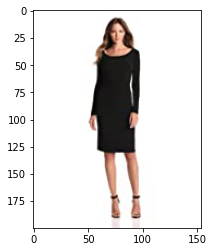

In [43]:
img = mpimg.imread(target_org_path)
imgplot = plt.imshow(img)
plt.show()

##### CANDIDATE IMAGE

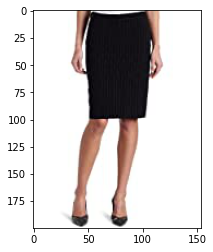

In [44]:
img = mpimg.imread(candidate_org_path)
imgplot = plt.imshow(img)
plt.show()

##### PRODUCED CAPTION and ORIGINAL CAPTION

In [45]:
def get_cap(cap_list):
    return " ".join([tok for tok in cap_list if tok not in ['[CLS]', '[SEP]', '[PAD]']])

produced_caption = produce_caption(model=tric_model, pair_id=IMAGE_PAIR_ID, vocab=vocab, max_len=MAX_LEN, device=device)
real_caption = [vocab.ids_to_tokens[id_.item()] for id_ in captions_batch[IMAGE_PAIR_ID]]

produced_caption = get_cap(produced_caption)
real_caption = get_cap(real_caption)

print("PRODUCED CAPTION")
print(produced_caption)

print("\n")

print("REAL CAPTION")
print(real_caption)

PRODUCED CAPTION
is longer black with longer sleeves


REAL CAPTION
is longer
